In [1]:
!where python


d:\geobank\GeoBank\myvenv1\python.exe
D:\anaconda3\python.exe
C:\Users\Ayan\AppData\Local\Programs\Python\Python310\python.exe
C:\Users\Ayan\AppData\Local\Microsoft\WindowsApps\python.exe


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold,train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import optuna
import json

In [3]:
df = pd.read_csv("../data/final/geo_features_us_bank_final.csv")
df = df.dropna(subset=["latitude", "longitude", "total_deposits"])

In [4]:
q1 = df["total_deposits"].quantile(0.20)
q3 = df["total_deposits"].quantile(0.80)
df = df[(df["total_deposits"] <= q1) | (df["total_deposits"] >= q3)]
df["is_high_performing"] = (df["total_deposits"] >= q3).astype(int)

In [5]:
X_full = df.copy()
train_data, test_data = train_test_split(X_full, stratify=X_full["is_high_performing"], test_size=0.2, random_state=42)

In [6]:
coords = train_data[["latitude", "longitude"]]
scores = {}
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(coords)
    scores[k] = silhouette_score(coords, labels)
best_k = max(scores, key=scores.get)
kmeans = KMeans(n_clusters=best_k, random_state=42)
train_data["geo_cluster"] = kmeans.fit_predict(train_data[["latitude", "longitude"]])
test_data["geo_cluster"] = kmeans.predict(test_data[["latitude", "longitude"]])

In [7]:
def add_features(df):
    df["log_nearest_distance"] = np.log1p(df["nearest_competitor_distance_km"])
    df["density_ratio"] = df["total_deposits"] / (df["branch_density_10km"] + 1)
    df["lat_lon_interaction"] = df["latitude"] * df["longitude"]
    return df

train_data = add_features(train_data)
test_data = add_features(test_data)

features = [
    "latitude", "longitude", "log_nearest_distance", "branch_density_10km",
    "geo_cluster", "state", "lat_lon_interaction", "density_ratio"
]

X_train = train_data[features]
y_train = train_data["is_high_performing"]
X_test = test_data[features]
y_test = test_data["is_high_performing"]

In [8]:
numeric_features = ["latitude", "longitude", "log_nearest_distance", "branch_density_10km", "geo_cluster", "lat_lon_interaction", "density_ratio"]
categorical_features = ["state"]
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [11]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "random_state": 42
    }
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(**params))
    ])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        probas = model.predict_proba(X_train.iloc[val_idx])[:, 1]
        scores.append(roc_auc_score(y_train.iloc[val_idx], probas))
    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2025-07-08 10:49:57,212] A new study created in memory with name: no-name-477502a9-0247-44ef-a4f3-f2885ba187f7
d:\geobank\GeoBank\myvenv1\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:49:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\geobank\GeoBank\myvenv1\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:49:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\geobank\GeoBank\myvenv1\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:49:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\geobank\GeoBank\myvenv1\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:49:58] WARNING: C:\act

In [12]:
best_params = study.best_params
best_params["eval_metric"] = "logloss"
best_params["use_label_encoder"] = False
best_params["random_state"] = 42

final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(**best_params))
])
final_model.fit(X_train, y_train)

d:\geobank\GeoBank\myvenv1\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:50:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


d:\geobank\GeoBank\myvenv1\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:50:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\geobank\GeoBank\myvenv1\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:50:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\geobank\GeoBank\myvenv1\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:50:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\geobank\GeoBank\myvenv1\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:50:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up

Stratified 5-Fold CV ROC AUC: 0.9998327759197323 +/- 0.00033444816053512794
Best Parameters: {'n_estimators': 111, 'max_depth': 7, 'learning_rate': 0.2748462789776829, 'subsample': 0.9208990118413021, 'colsample_bytree': 0.7503454472034091, 'gamma': 2.095948784885442, 'reg_alpha': 0.0990796347225612, 'reg_lambda': 0.27994694521655006, 'eval_metric': 'logloss', 'use_label_encoder': False, 'random_state': 42}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00       114

    accuracy                           1.00       228
   macro avg       1.00      1.00      1.00       228
weighted avg       1.00      1.00      1.00       228

ROC AUC: 1.0


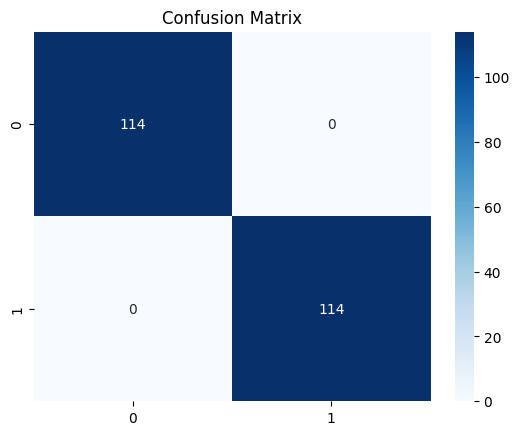

In [13]:
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring="roc_auc")
print("Stratified 5-Fold CV ROC AUC:", np.mean(cv_scores), "+/-", np.std(cv_scores))

# Final Test Performance
y_pred = final_model.predict(X_test)
print("Best Parameters:", best_params)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1]))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [15]:
report_dict = classification_report(y_test, y_pred, output_dict=True)

# 2. Calculate ROC AUC
roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])

# 3. Combine into one result dictionary
results = {
    "classification_report": report_dict,
    "roc_auc": roc_auc
}

# 4. Save to JSON file
with open("../backend/api_outputs/classification_results.json", "w") as f:
    json.dump(results, f, indent=2)